# Project 3: Web APIs & Classification

## Step 4: Repeating with TF-IDF

### Further data processing
Similar to Step 3

### TF-IDF Vectorization
- TF-IDF Vectorization in this current step

### Modelling
- Logistic Regression
- Multinomial Bayesian
- Random Forest

### Importing libaries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, auc

### Loading data from csv files

In [2]:
# load data from csv files saved in Steps 1 and 2
pd_dem = pd.read_csv("../data/democrats_comments.csv")
pd_con = pd.read_csv("../data/conservatives_comments.csv")

In [3]:
# add label: democrats as 1, con as -1
pd_dem["label"] = 1
pd_con["label"] = -1

In [4]:
data = pd.concat([pd_dem, pd_con])
data.reset_index(inplace=True)

In [5]:
data.shape

(1990, 7)

In [6]:
data.head()

,index,name,title,url_comments,comments,selftext,label
0,0,t3_kv4lr7,House Democrats launch second impeachment of T...,https://www.reddit.com/r/democrats/comments/kv...,Are they waiting for a response from Pence re ...,The House Article of Impeachment will be intro...,1
1,1,t3_kvg3xu,Do I have to,https://www.reddit.com/r/democrats/comments/kv...,Every time I look at Pence he reminds me of S...,NaN,1
2,2,t3_kv4oca,Camp Auschwitz guy identified,https://www.reddit.com/r/democrats/comments/kv...,Trump thought the riot looked low class I wo...,NaN,1
3,3,t3_kvekkt,No Crawling Back,https://www.reddit.com/r/democrats/comments/kv...,I just love how AOC takes no prisoners. She la...,NaN,1
4,4,t3_kvfqwa,Use the 14th Amendment to ban Trump,https://www.reddit.com/r/democrats/comments/kv...,Yep what s more Democrats got ahold of the S...,NaN,1


In [7]:
data["label"].value_counts(normalize=True)

 1    0.501005
-1    0.498995
Name: label, dtype: float64

### Base Case accuracy

Base Case Accuracy
The two classes are of roughly equal size, hence the base case accuracy is 50%. The goal of modelling is to build a model to classify at an accuracy substantially higher than 50%

### Function for cleaning up the text

In [8]:
def process_text(text):
    # Function to convert a raw text to a string of meaning words

    words = str(text)
    # Remove non-letters.
    try:
        words = re.sub("[^a-zA-Z]", " ", text)
    except:
        pass
    

    # Convert to lower case, split into individual words (list)
    words = words.lower().split()
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(i) for i in words]
    words = lemmatized_words
    
    #Convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    #Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [9]:
text = data.loc[0, "comments"]
text

'Are they waiting for a response from Pence re 25th before moving full speed ahead with impeachment  Yeah but when are they voting on it  I need to know when to turn on CSPAN  \n\n\nEdit  looks like Wednesday.. for like  no reason. This is irresponsible. Do it today  Your only job is voting on stuff.. and it s still business hours. It s what we pay you for. Sorry  I m kinda pissed. I read there s gonna be more violence  amp  the National Guard are being issued weapons. Good. Even if they don t remove him  which they probably won t be able to  this is the right thing to do.'

In [10]:
text = process_text(text)
text

'waiting response penny th moving full speed ahead impeachment yeah voting need know turn cspan edit look like wednesday like reason irresponsible today job voting stuff still business hour pay sorry kinda pissed read gonna violence amp national guard issued weapon good even remove probably able right thing'

#### Check the data types of fields

In [11]:
data.dtypes

index            int64
name            object
title           object
url_comments    object
comments        object
selftext        object
label            int64
dtype: object

#### Check null values

In [12]:
data.isnull().sum()

index              0
name               0
title              0
url_comments       0
comments         513
selftext        1911
label              0
dtype: int64

Some empty values in comments and selftext.

### Further processing text

In [13]:
# Processing text
data["title"] = data["title"].map(process_text)
data["comments"] = data["comments"].map(process_text)
data["selftext"] = data["selftext"].map(process_text)

In [14]:
data[["title", "comments", "selftext"]].head()

,title,comments,selftext
0,house democrat launch second impeachment trump...,waiting response penny th moving full speed ah...,house article impeachment introduced et today ...
1,,every time look penny reminds steve carell off...,nan
2,camp auschwitz guy identified,trump thought riot looked low class wonder shi...,nan
3,crawling back,love aoc take prisoner lay hold accountable wa...,nan
4,use th amendment ban trump,yep democrat got ahold senate house white hous...,nan


#### Processing Title + Comments + Selftext

In [15]:
### Combining three fields: Title + Comments + Selftext as Inputs (X)# Create data for model inputs - title and comments and selftext
# both X and y are to be lists
X = data["title"] + " " + data["comments"] + " " + data["selftext"]
y = data["label"]

#### Splitting training and test datasets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [17]:
X_train.shape

(1492,)

In [18]:
len(y_train)

1492

## TF-IDF Vectorizer

In [19]:
tvec = TfidfVectorizer(ngram_range=(1,2))

In [20]:
X_train_tvec = tvec.fit_transform(X_train).todense()
X_train_tvec_df = pd.DataFrame(X_train_tvec, columns = tvec.get_feature_names())
X_train_tvec_df.shape

(1492, 80055)

In [21]:
X_train_tvec_df.head()

,aaaanndddd,aaaanndddd someone,aad,aad amp,aae,aae ddf,aaouww,aaouww cnfwaxy,ab,ab ab,...,zuck,zuck need,zuckerberg,zuckerberg biden,zuckerberg bloomberg,zuckerberg cancer,zuckerberg censor,zuckerberg corruption,zuckerberg eye,zuckerberg shut
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# find out how many times each word appear in the corpus by creating a 'Total' row at the end of the dataframe:
X_train_tvec_df.loc['Total']= X_train_tvec_df.sum(axis=0)
X_train_tvec_df.loc['Total',:].sort_values(ascending=False)

nan                 57.329407
nan nan             40.712352
trump               31.587999
wa                  21.054879
people              16.861338
                      ...    
damien               0.017946
damien thaddeus      0.017946
lackey continues     0.017946
ej http              0.017946
voter http           0.017946
Name: Total, Length: 80055, dtype: float64

In [23]:
### Create a DataFrame for the above Total Word Count, and then check, for each specified frequency (2, 10, 50, etc), what is the associated number of features (words) that appear in the corpus.
X_train_total_df = pd.DataFrame(X_train_tvec_df.loc['Total',:].sort_values(ascending=False))
X_train_total_df.head()

,Total
nan,57.329407
nan nan,40.712352
trump,31.587999
wa,21.054879
people,16.861338


Similar redundant words to be removed as additional stop words

In [24]:
print(len(X_train_total_df.loc[X_train_total_df['Total'] <= 1]))
print(len(X_train_total_df.loc[X_train_total_df['Total'] <= 2]))
print(len(X_train_total_df.loc[X_train_total_df['Total'] <= 10]))
print(len(X_train_total_df.loc[X_train_total_df['Total'] <= 50]))

78905
79584
80035
80054


In [25]:
# Features with the highest TFIDF scores
threshold = 10
len(X_train_total_df[X_train_total_df.Total > threshold].index.to_list())

20

<BarContainer object of 20 artists>

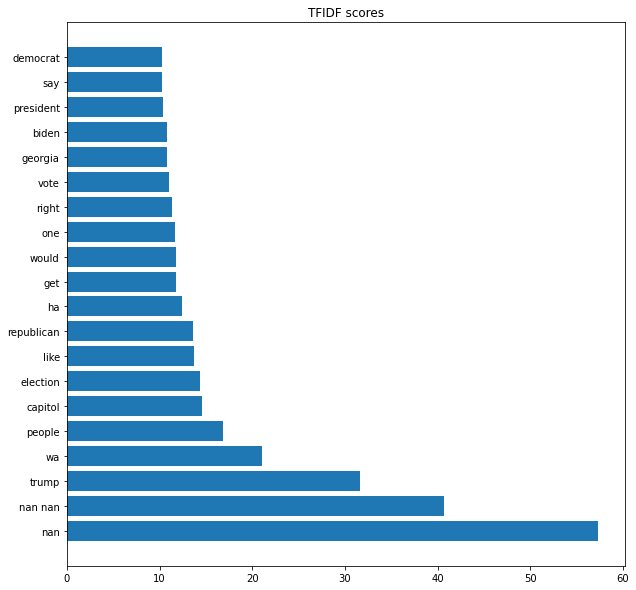

In [26]:
# plot histogram to observe the distribution
figure = plt.figure(figsize=[10,10])
plt.title("TFIDF scores")
plt.barh(X_train_total_df[X_train_total_df.Total > threshold].index.to_list(), X_train_total_df[X_train_total_df.Total > threshold]["Total"])

In [27]:
### Additional stop words

In [28]:
additional_stop_words = ["nan", "nan nan", "wa", "ha", "would"]

### Using Logistic Regression

In [29]:
pipe = Pipeline([
    ("tvec", TfidfVectorizer(ngram_range=(1, 2), stop_words=additional_stop_words)),
    ("lr", LogisticRegression())
    ])

In [30]:
pipe_params = {
    'tvec__max_features': [30, 60, 90],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.2, .25, .3],
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs = -1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words=['nan',
                                                                    'nan nan',
                                                                    'wa', 'ha',
                                                                    'would'])),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.2, 0.25, 0.3],
                         'tvec__max_features': [30, 60, 90],
                         'tvec__min_df': [2, 3]})

In [31]:
gs.cv_results_['mean_test_score']

array([0.59854998, 0.59854998, 0.626693  , 0.626693  , 0.63139772,
       0.63005769, 0.59052547, 0.59386995, 0.62803304, 0.6273619 ,
       0.62335975, 0.62537317, 0.59052547, 0.59386995, 0.62803304,
       0.6273619 , 0.62335975, 0.62537317])

In [32]:
print(f'Validation best score: {gs.best_score_}')
print(f'Best params: {gs.best_params_}')
print(f'Training score: {gs.score(X_train, y_train)}')
print(f'Test score: {gs.score(X_test, y_test)}')

Validation best score: 0.6313977239568136
Best params: {'tvec__max_df': 0.2, 'tvec__max_features': 90, 'tvec__min_df': 2}
Training score: 0.6802949061662198
Test score: 0.6345381526104418


#### Increasing max_features

In [33]:
pipe_params = {
    'tvec__max_features': [300, 400, 500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.2, .25, .3],
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs = -1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words=['nan',
                                                                    'nan nan',
                                                                    'wa', 'ha',
                                                                    'would'])),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.2, 0.25, 0.3],
                         'tvec__max_features': [300, 400, 500],
                         'tvec__min_df': [2, 3]})

In [34]:
gs.cv_results_['mean_test_score']

array([0.69973738, 0.69973738, 0.71315346, 0.71114453, 0.71852259,
       0.71718255, 0.69503939, 0.69771947, 0.70913335, 0.71583578,
       0.71918475, 0.71852259, 0.69503939, 0.69771947, 0.70913335,
       0.71583578, 0.71918475, 0.71852259])

In [35]:
print(f'Validation best score: {gs.best_score_}')
print(f'Best params: {gs.best_params_}')
print(f'Training score: {gs.score(X_train, y_train)}')
print(f'Test score: {gs.score(X_test, y_test)}')

Validation best score: 0.7191847545509641
Best params: {'tvec__max_df': 0.25, 'tvec__max_features': 500, 'tvec__min_df': 2}
Training score: 0.8398123324396782
Test score: 0.7389558232931727


Better performance, though there are signs of overfitting the entire training set

### Using Multinomial NB

In [36]:
pipe2 = Pipeline([
    ("tvec", TfidfVectorizer(stop_words=additional_stop_words, ngram_range=(1,2))),
    ("nb", MultinomialNB())
    ])

In [ ]:
pipe_params = {
    'tvec__max_features': [600, 800, 1000],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [.05, .1, .15, .2],
}
gs2 = GridSearchCV(pipe2, param_grid=pipe_params, cv=5, n_jobs = -1)
gs2.fit(X_train, y_train)

In [ ]:
gs2.cv_results_['mean_test_score']

In [ ]:
print(f'Validation best score: {gs2.best_score_}')
print(f'Best params: {gs2.best_params_}')
print(f'Training score: {gs2.score(X_train, y_train)}')
print(f'Test score: {gs2.score(X_test, y_test)}')

Better performance using TFIDF and Multinomial, compared to CountVectorizator and Multinomial

### Using Random Forest

In [ ]:
pipe3 = Pipeline([
    ("tvec", TfidfVectorizer(stop_words=additional_stop_words, ngram_range=(1,2))),
    ("clf", RandomForestClassifier(max_depth=2, random_state=42))
    ])

In [ ]:
pipe_params = {
    'tvec__max_features': [600, 800, 1000],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [.05, .1, .15, .2],
}
gs3 = GridSearchCV(pipe3, param_grid=pipe_params, cv=5, n_jobs = -1)
gs3.fit(X_train, y_train)

In [ ]:
print(f'Validation best score: {gs3.best_score_}')
print(f'Best params: {gs3.best_params_}')
print(f'Training score: {gs3.score(X_train, y_train)}')
print(f'Test score: {gs3.score(X_test, y_test)}')

Not very good performance compared to Multinomial and Logistic Regresssion